In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys
from scipy.stats import pearsonr, spearmanr, normaltest
from ipyparallel import Client
import time

from umap import umap_ as umap
import networkx as nx

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

NARROW_COLOR = '#ADD8EC'
BROAD_COLOR = '#FF69B4'

did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']#['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
no_cloudy_animals = ['BS_119','BS_131','BS_139','BS_191']#Not including 111 since it learned
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']

ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
sham_1_animals = ['AE_267','AO_273','AE_312']
sham_2_animals = ['AE_287']#301
opsin_control_animals = ['AE_287']#Fig 4c

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
wav_directory = '..\\..\\Data\\Waveforms_Cache'
opswav_directory = '..\\..\\Data\\Waveforms_Cache_Opsin'
beh_directory = '..\\..\\Data\\Behavioor'
ops_directory = '..\\..\\Data\\Opsin_Cache'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [3]:
# print(animals)

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Reviewer 1\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

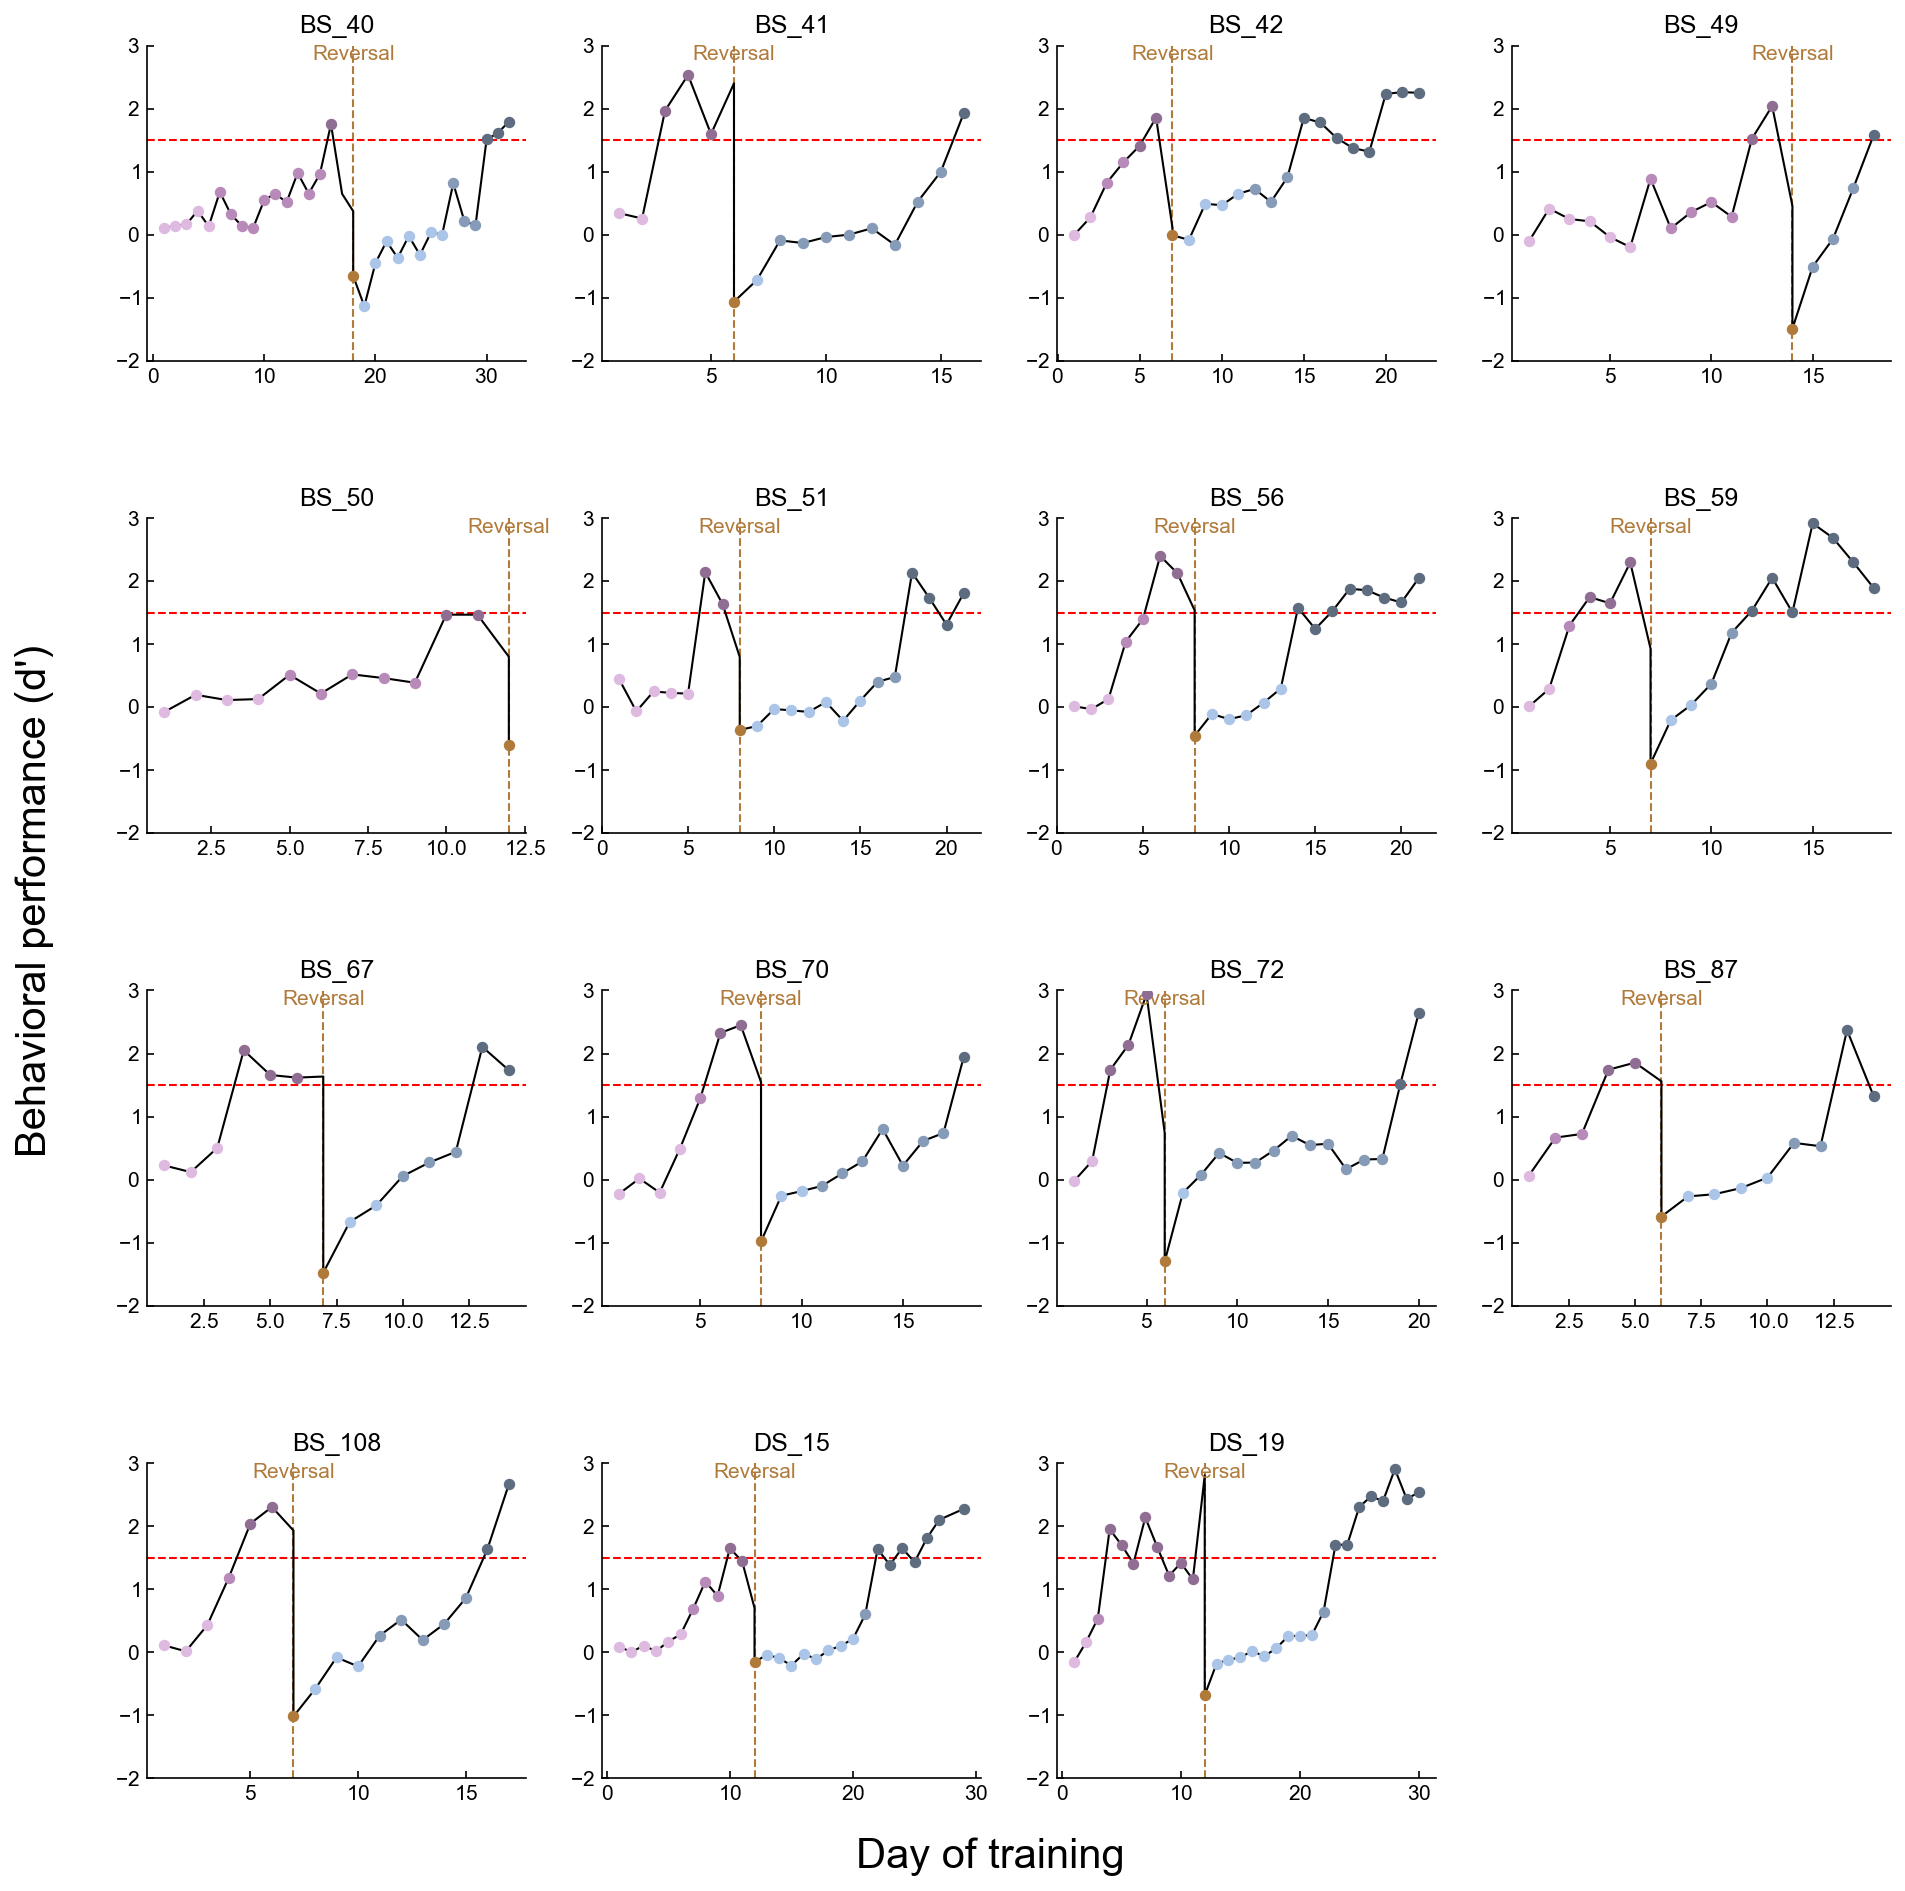

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


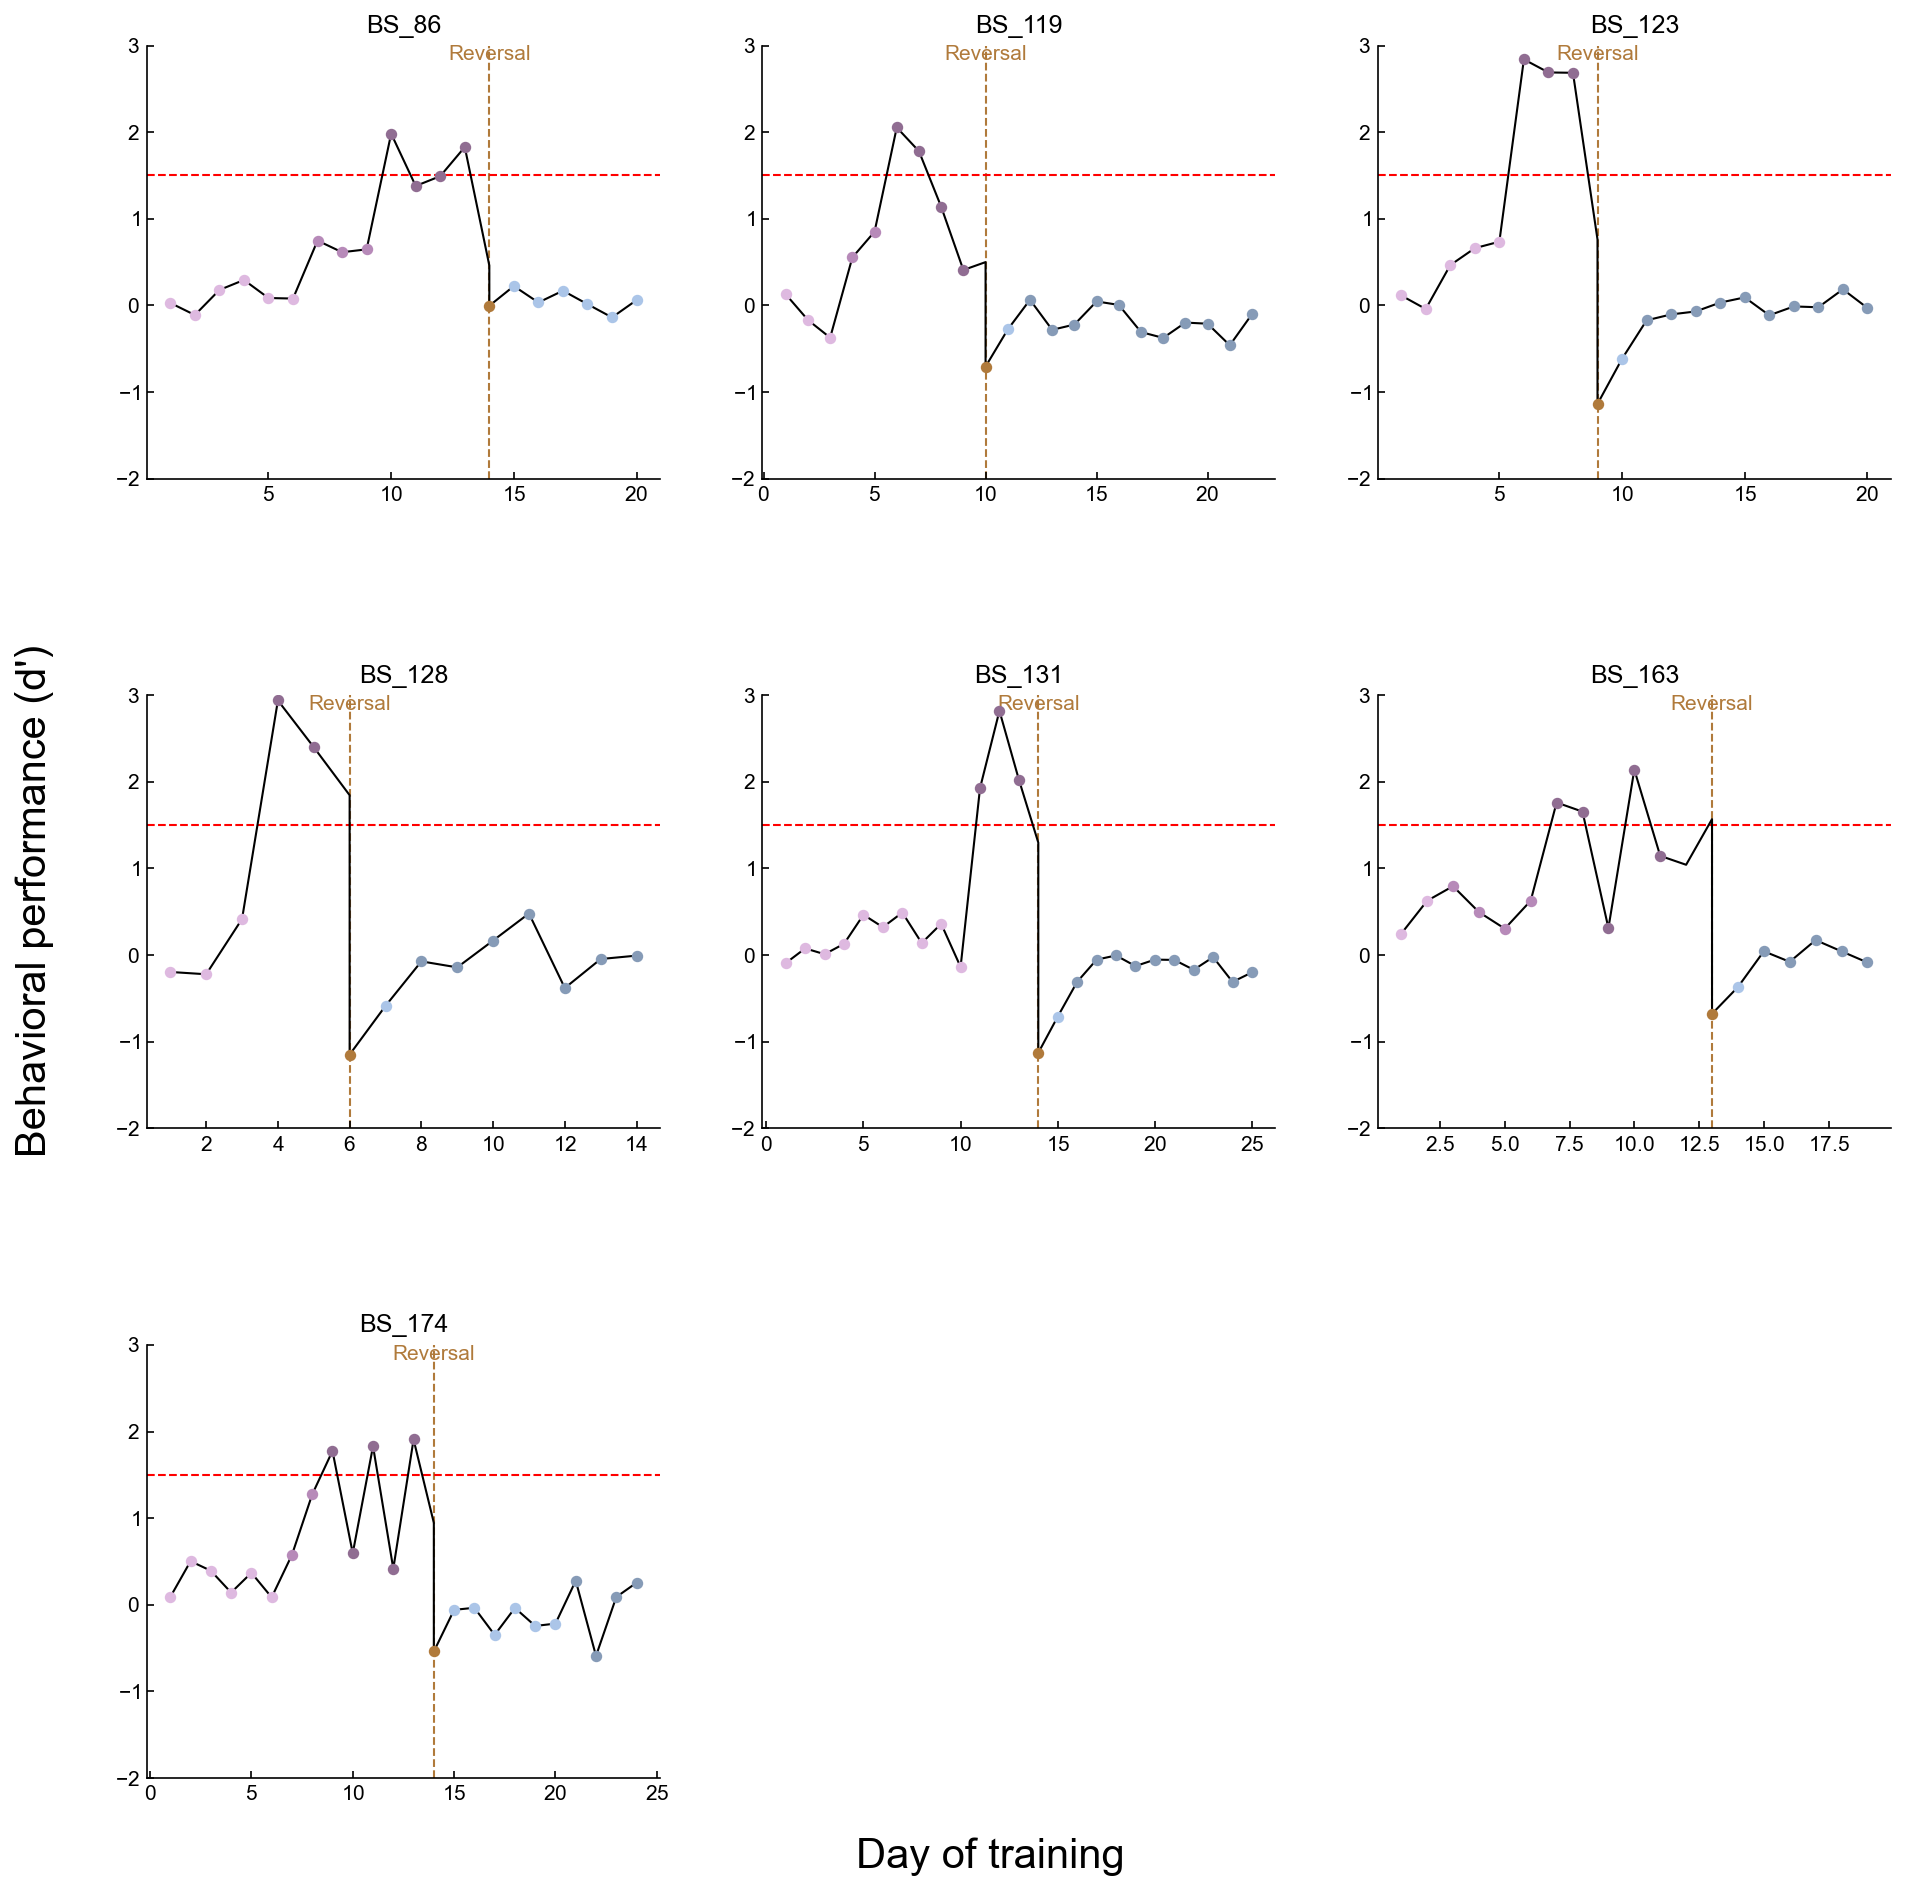

posx and posy should be finite values
posx and posy should be finite values


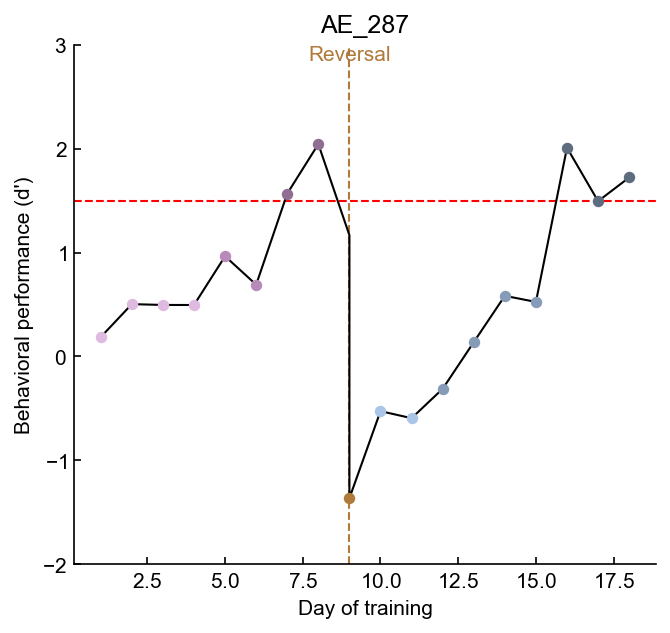

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(ephys_animals,animalBehaviors,plot=True,noTrim=False)
learning_phases2,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
# learning_phasesx,_,_ = ilep.calculateLearningPhasesV2(['BS_111'],animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
learning_phases3,_,_ = ilep.calculateLearningPhasesV2(opsin_control_animals,animalBehaviors,plot=True,noTrim=False)
for d in learning_phases2:
    learning_phases[d] = learning_phases2[d]
for d in learning_phases3:
    learning_phases[d] = learning_phases3[d]

In [6]:
EnumSessionOps = []
EnumClustOps = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    
    if session in ['BS_174_5_opto_AC.pickle']:     #This session excluded due to excessive gliosis (prevented recording the two days prior. Retired immediately after)
        continue
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['opto nonreversal','opto switch','opto reversal']:
        continue
        
    if sessionfile.meta.animal not in did_not_learn_animals:
        continue
        
    if hasattr(animalBehaviors[sessionfile.meta.animal],'cloudiness') and sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionOps.append(session)
        EnumClustOps.append(clust)

100%|██████████| 167/167 [00:09<00:00, 18.52it/s]


In [7]:
EILphasesOps = np.full_like(EnumSessionOps,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionOps)):
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        day_after_reversal = day - animalBehaviors[animal].reversal
            
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphasesOps[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesOps[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesOps[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesOps[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 2:
            EILphasesOps[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 4:
            EILphasesOps[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal >= 5:
            EILphasesOps[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 850/850 [00:35<00:00, 24.23it/s] 

errors for: []


Abnormal crossings detected at BS_174_2_opto_AC.pickle cluster 290


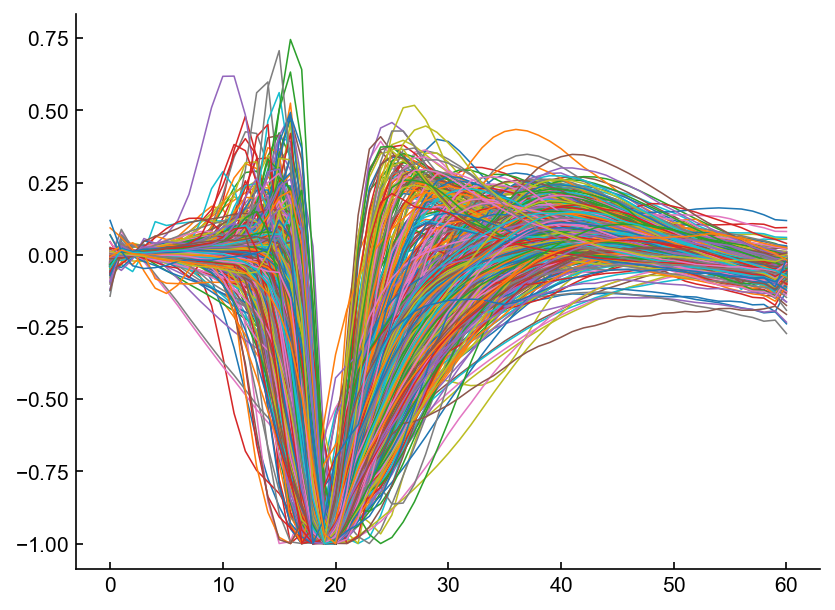

In [13]:
FRmods = []
FRmods_on = []
FRmods_off = []
half_widths = []

for session,clust in zip(EnumSessionOps,EnumClustOps):
    session_prefix = session[:-7]
    session_waveform = session_prefix+'_waveforms.pickle'

    sessionfile = ilep.loadSessionCached(ops_directory,session)
    try:
        with open(os.path.join(opswav_directory,session_waveform), 'rb') as f:
            waveforms = pickle.load(f)
    except Exception as e:
        # print(f"failed to find {session_waveform}: {e}")
        continue
        pass

    waveform = waveforms[clust]

    if np.min(waveform) > -0.9 or np.max(waveform) > 0.9:
        continue

    plt.plot(waveform,lw=0.75)

    sample_of_trough = np.argmin(waveform)
    half_width_crossings = np.where(np.diff(np.sign(waveform + 0.5)))[0]
    if len(half_width_crossings) != 2:
        print(f"Abnormal crossings detected at {session} cluster {clust}")
        continue
    half_width_ms = np.ptp(half_width_crossings) / 30

    half_widths.append(half_width_ms)
    FRmods.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
    FRmods_on.append(sessionfile.responsiveness[clust]['laser_on'].FRmodulation)
    FRmods_off.append(sessionfile.responsiveness[clust]['laser_off'].FRmodulation)

plt.savefig('C:\\Users\\4thgr\\Downloads\\AllwaveformsOpsin.pdf')

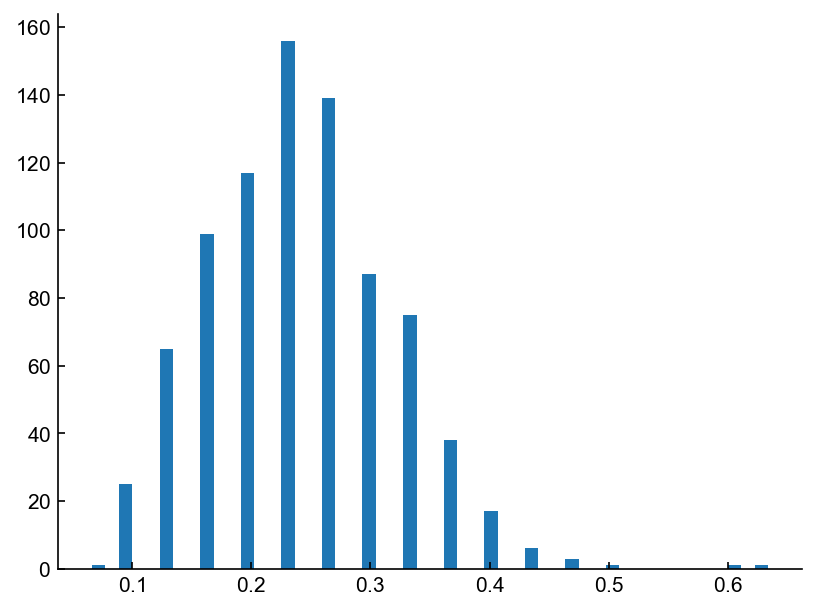

In [9]:
plt.hist(half_widths,bins=50)
plt.savefig('C:\\Users\\4thgr\\Downloads\\AllHalfWidthsOpsin.pdf')

Pearson (log10), p = 0.17402553794598824
Spearman,        p = 0.1509959642169282


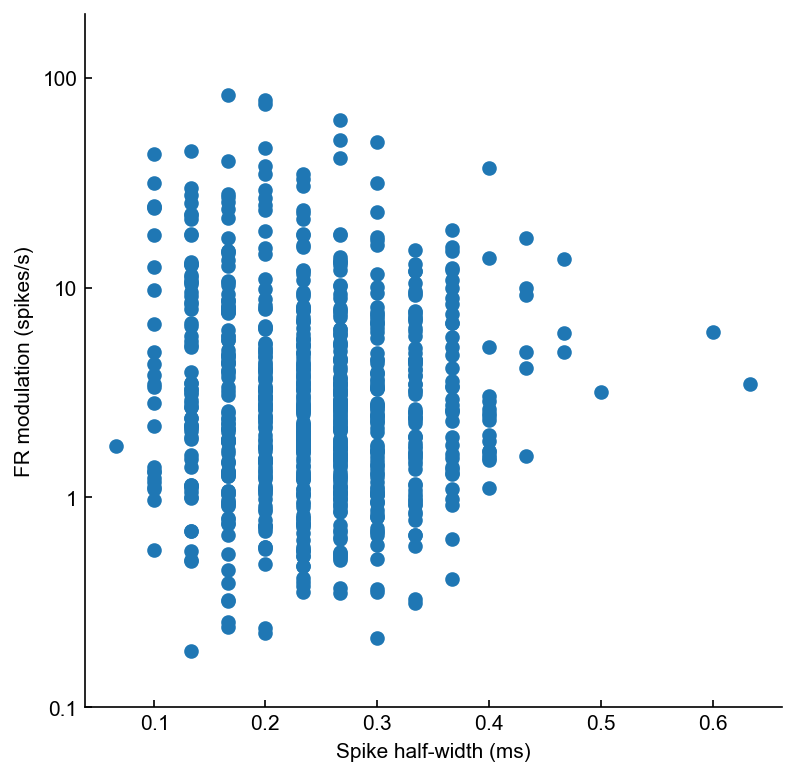

In [10]:
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(half_widths,FRmods)

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])

ax.set_xlabel('Spike half-width (ms)')
ax.set_ylabel('FR modulation (spikes/s)')

A,B = ilep.paired_rmnan(half_widths,np.log10(FRmods))
print(f"Pearson (log10), p = {pearsonr(A,B).pvalue}")
A,B = ilep.paired_rmnan(half_widths,FRmods)
print(f"Spearman,        p = {spearmanr(A,B).pvalue}")

plt.savefig('C:\\Users\\4thgr\\Downloads\\HalfWidthVsFRmodOpsin.pdf')

# Wavemap

In [14]:
UMAP_reducer_seed = 42
louvain_seed = 80

In [15]:
normWFs = []
for session,clust in zip(EnumSessionOps,EnumClustOps):
    session_prefix = session[:-7]
    session_waveform = session_prefix+'_waveforms.pickle'

    sessionfile = ilep.loadSessionCached(ops_directory,session)
    try:
        with open(os.path.join(opswav_directory,session_waveform), 'rb') as f:
            waveforms = pickle.load(f)
    except Exception as e:
        # print(f"failed to find {session_waveform}: {e}")
        continue
        pass

    waveform = waveforms[clust]

    if np.min(waveform) > -0.9 or np.max(waveform) > 0.9:
        continue
        
    sample_of_trough = np.argmin(waveform)
    half_width_crossings = np.where(np.diff(np.sign(waveform + 0.5)))[0]
    if len(half_width_crossings) != 2:
        print(f"Abnormal crossings detected at {session} cluster {clust}")
        continue
    half_width_ms = np.ptp(half_width_crossings) / 30

    normWFs.append(waveforms[clust])
normWFs = np.array(normWFs)
# normWFs = np.full((len(subset_df),53),np.nan)
# for idx,UUID in enumerate(subset_df.index):
#     normWFs[idx,:] = subset_df.loc[UUID]['mean waveform']

Abnormal crossings detected at BS_174_2_opto_AC.pickle cluster 290


In [16]:
normWFs.shape

(831, 61)

In [17]:
reducer = umap.UMAP(n_neighbors=15, random_state=UMAP_reducer_seed,n_jobs=1)
mapper = reducer.fit(normWFs)

G = nx.from_scipy_sparse_array(mapper.graph_)
temp_solution = nx.community.louvain_communities(G,resolution = 0.8,seed=80)
# print(np.sum([(len(l) for l in clustering_solution]))

clustering_solution = np.full_like(list(G.nodes),np.nan)
for idx in range(len(clustering_solution)):
    membership = [np.isin(idx,list(t)) for t in temp_solution]
    cluster_ID = np.where(membership)[0]
    clustering_solution[idx] = cluster_ID

modularity = nx.algorithms.community.quality.modularity(G, temp_solution)
print(modularity)

C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
C:\Users\4thgr\AppData\Local\Temp\ipykernel_33580\379316334.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  clustering_solution[idx] = cluster_ID


0.7207873800664879


C:\Users\4thgr\AppData\Local\Temp\ipykernel_33580\522930585.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('turbo')
C:\Users\4thgr\AppData\Local\Temp\ipykernel_33580\522930585.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X,Y, marker='o', c=rgba,zorder=0,s=30,lw=1.5)


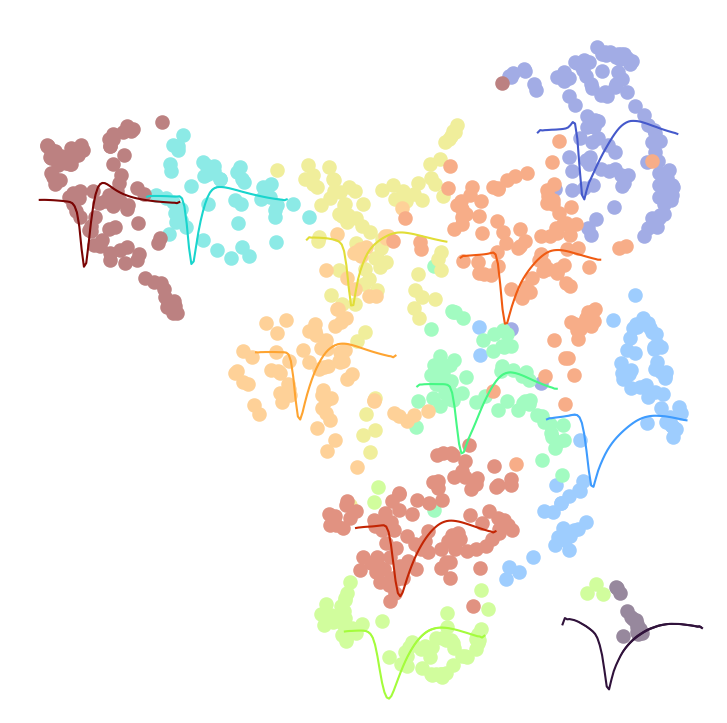

In [18]:
embedding = reducer.fit_transform(normWFs)
umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(normWFs)
umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(6,6))
ax.spines[['left','right','top','bottom']].set_visible(False)
X = np.array(umap_df['x'].tolist())
Y = np.array(umap_df['y'].tolist())
xlim = [np.min(X)-np.ptp(X)*0.05,np.max(X)+np.ptp(X)*0.05]
ylim = [np.min(Y)-np.ptp(Y)*0.05,np.max(Y)+np.ptp(Y)*0.05]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_yticks([])
ax.fill_between(xlim,ylim[0],ylim[1],lw=0,fc='white',alpha=0.5,zorder=4)

unique_waveform_clusters = np.unique(clustering_solution)
for wfclust in unique_waveform_clusters:

    #Calculate clustering of points
    mask = clustering_solution == wfclust

    X = np.array(umap_df['x'].tolist())
    Y = np.array(umap_df['y'].tolist())
    X = X[mask]
    Y = Y[mask]

    #Calculate waveform
    clust_waveforms = normWFs[mask,:]
    mean_waveform = np.mean(clust_waveforms,axis=0)
    sem_waveform = sem(clust_waveforms,axis=0)

    #Calculate color
    cmap = mpl.cm.get_cmap('turbo')
    rgba = cmap(wfclust/np.max(unique_waveform_clusters))

    #FRmod colors
    mn = 3.5
    spread = 2.5
    colors = NCR_CR_cmap( (np.array(FRmods)[mask]-(mn-spread/2))/ (spread) )

    #Plot scatter
    ax.scatter(X,Y, marker='o', c=rgba,zorder=0,s=30,lw=1.5)

    #Plot waveform
    meanX = np.mean(X)
    meanY = np.mean(Y)
    total_x_range = np.abs(xlim[1]-xlim[0])
    total_y_range = np.abs(ylim[1]-ylim[0])
    xrange = np.linspace(meanX-total_x_range*0.1,meanX+total_x_range*0.1,num=61)
    y_adj = mean_waveform * total_y_range*0.1 + meanY
    ysem_adj = sem_waveform * total_y_range*0.1
    ax.plot(xrange,y_adj,c=rgba,lw=1,zorder=5)
    ax.fill_between(xrange,y_adj-ysem_adj,y_adj+ysem_adj,alpha=1,lw=0,fc=rgba,zorder=4)

plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersOpsin.pdf')

C:\Users\4thgr\AppData\Local\Temp\ipykernel_20788\1216096646.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('turbo')
C:\Users\4thgr\AppData\Local\Temp\ipykernel_20788\1216096646.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X+Xpos,Y, marker='o', c=rgba,zorder=0,clip_on=False)


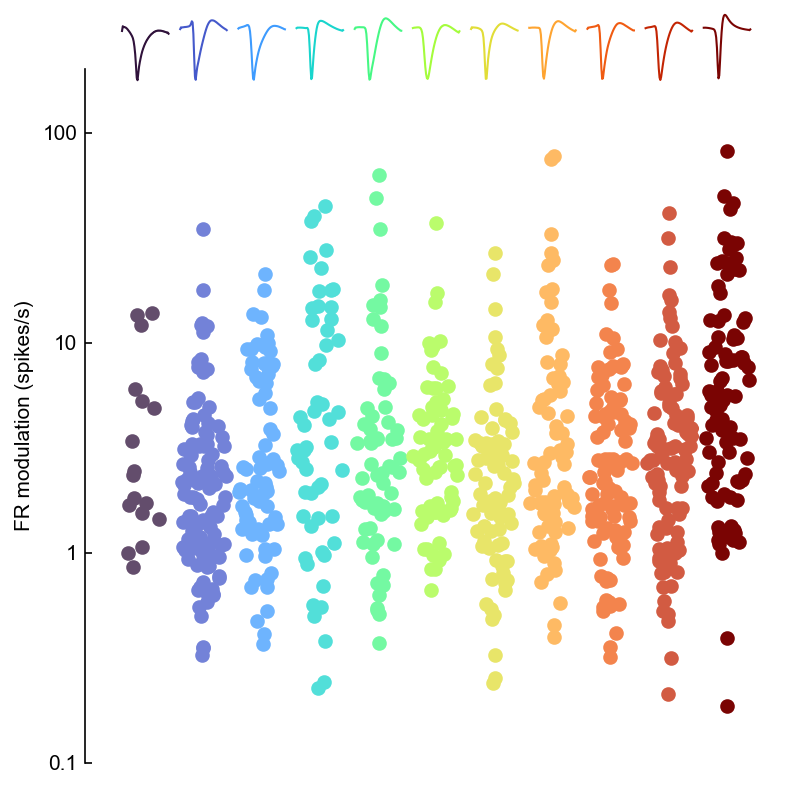

In [16]:
# embedding = reducer.fit_transform(normWFs)
# umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
# umap_df['waveform'] = list(normWFs)
# umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(6,6))
ax.spines[['right','top','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_ylabel('FR modulation (spikes/s)')
ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between([-0.5,9.5],ylim[0],ylim[1],lw=0,fc='white',alpha=0.25,zorder=4)

unique_waveform_clusters = np.unique(clustering_solution)
for Xpos,wfclust in enumerate(unique_waveform_clusters):

    #Calculate clustering of points
    mask = clustering_solution == wfclust

    #Calculate waveform
    clust_waveforms = normWFs[mask,:]
    mean_waveform = np.mean(clust_waveforms,axis=0)
    sem_waveform = sem(clust_waveforms,axis=0)
    
    #Calculate color
    cmap = mpl.cm.get_cmap('turbo')
    rgba = cmap(wfclust/np.max(unique_waveform_clusters))
    
    #Plot scatter
    X,_ = ilep.violin(np.log10(np.array(FRmods)[mask]))
    Y = np.array(FRmods)[mask]
    ax.scatter(X+Xpos,Y, marker='o', c=rgba,zorder=0,clip_on=False)

    #Plot waveform
    meanX = Xpos
    meanY = 2.5
    total_x_range = 0.4
    total_y_range = 0.25
    xrange = np.linspace(meanX-total_x_range,meanX+total_x_range,num=61)
    y_adj = mean_waveform * total_y_range + meanY
    ysem_adj = sem_waveform * total_y_range
    ax.plot(xrange,10**(y_adj),c=rgba,lw=1,zorder=5,clip_on=False)
    ax.fill_between(xrange,10**(y_adj-ysem_adj),10**(y_adj+ysem_adj),alpha=1,lw=0,fc=rgba,zorder=4,clip_on=False)

# ax.plot([2.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.plot([3.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.plot([7.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.text(1,-500,'Broad',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(3,-500,'N. Biphasic',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(5.5,-500,'N. Triphasic',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(8,-500,'Upward(?)',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# pass

plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersVsFRmodOpsin.pdf')

In [17]:
A,B = ilep.paired_rmnan(clustering_solution,FRmods)
df = pd.DataFrame({"cluster": A, "FRmod": B})
anova = pg.anova(data=df, dv='FRmod', between=['cluster'], detailed=True)
print(anova)

    Source           SS   DF          MS         F         p-unc       np2
0  cluster   4364.63359   10  436.463359  6.657191  5.493046e-10  0.075344
1   Within  53564.71755  817   65.562690       NaN           NaN       NaN


In [21]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def dark(chex,val=0.2):
    crgb = np.array(hex_to_rgb(chex)) / 255
    hsv = np.array(colorsys.rgb_to_hsv(crgb[0],crgb[1],crgb[2]))
    hsv[2] -= val
    crgb = np.array(colorsys.hsv_to_rgb(hsv[0],hsv[1],hsv[2]))*255
    crgb = np.array(crgb,dtype=int)
    hex = rgb_to_hex(tuple(crgb))
    return hex

# Broad / Narrow

In [19]:
narrow_clusters = [3,10]
narrow2_clusters = []
broad_clusters = [0,1,2,4,5,8,9]
none_clusters = [6,7]

new_clustering_solution = np.zeros_like(clustering_solution)
narrow_mask = np.isin(clustering_solution,narrow_clusters)
narrow2_mask = np.isin(clustering_solution,narrow2_clusters)
broad_mask = np.isin(clustering_solution,broad_clusters)
none_mask = np.isin(clustering_solution,none_clusters)
new_clustering_solution[broad_mask] += 1
new_clustering_solution[none_mask] += 2
new_clustering_solution[narrow2_mask] += 3

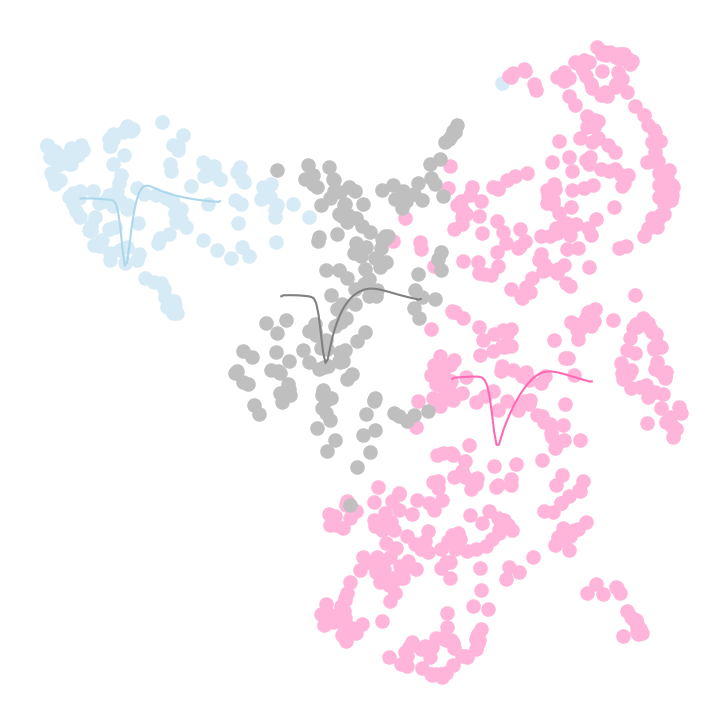

In [23]:
embedding = reducer.fit_transform(normWFs)
umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(normWFs)
umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(6,6))
ax.spines[['left','right','top','bottom']].set_visible(False)
X = np.array(umap_df['x'].tolist())
Y = np.array(umap_df['y'].tolist())
xlim = [np.min(X)-np.ptp(X)*0.05,np.max(X)+np.ptp(X)*0.05]
ylim = [np.min(Y)-np.ptp(Y)*0.05,np.max(Y)+np.ptp(Y)*0.05]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_yticks([])
ax.fill_between(xlim,ylim[0],ylim[1],lw=0,fc='white',alpha=0.5,zorder=4)

unique_waveform_clusters = np.unique(new_clustering_solution)
for wfclust in unique_waveform_clusters:

    #Calculate clustering of points
    mask = new_clustering_solution == wfclust

    X = np.array(umap_df['x'].tolist())
    Y = np.array(umap_df['y'].tolist())
    X = X[mask]
    Y = Y[mask]

    #Calculate waveform
    clust_waveforms = normWFs[mask,:]
    mean_waveform = np.mean(clust_waveforms,axis=0)
    sem_waveform = sem(clust_waveforms,axis=0)

    #Calculate color
    # cmap = mpl.cm.get_cmap('turbo')
    # rgba = cmap(wfclust/np.max(unique_waveform_clusters))
    colors = [NARROW_COLOR,BROAD_COLOR,'#808080','#FFFFFF']
    rgba = colors[wfclust]

    #FRmod colors
    mn = 3.5
    spread = 2.5
    colors = NCR_CR_cmap( (np.array(FRmods)[mask]-(mn-spread/2))/ (spread) )

    #Plot scatter
    ax.scatter(X,Y, marker='o', c=rgba,zorder=0,s=30,lw=1.5)

    #Plot waveform
    meanX = np.mean(X)
    meanY = np.mean(Y)
    total_x_range = np.abs(xlim[1]-xlim[0])
    total_y_range = np.abs(ylim[1]-ylim[0])
    xrange = np.linspace(meanX-total_x_range*0.1,meanX+total_x_range*0.1,num=61)
    y_adj = mean_waveform * total_y_range*0.1 + meanY
    ysem_adj = sem_waveform * total_y_range*0.1
    ax.plot(xrange,y_adj,c=rgba,lw=1,zorder=5)
    ax.fill_between(xrange,y_adj-ysem_adj,y_adj+ysem_adj,alpha=1,lw=0,fc=dark(rgba),zorder=4)

plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersOpsin.pdf')

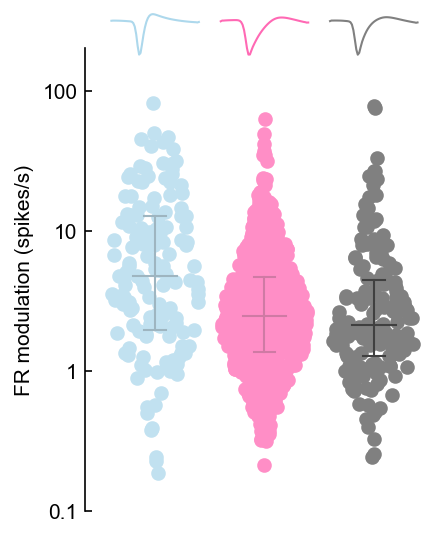

In [25]:
# embedding = reducer.fit_transform(normWFs)
# umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
# umap_df['waveform'] = list(normWFs)
# umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(3,4))
ax.spines[['right','top','bottom']].set_visible(False)
ax.set_xticks([])
ylab = ax.set_ylabel('FR modulation (spikes/s)')
ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between([-0.5,1.5],ylim[0],ylim[1],lw=0,fc='white',alpha=0.25,zorder=4)

unique_waveform_clusters = np.unique(new_clustering_solution)
for Xpos,wfclust in enumerate(unique_waveform_clusters):

    #Calculate clustering of points
    mask = new_clustering_solution == wfclust

    #Calculate waveform
    clust_waveforms = normWFs[mask,:]
    mean_waveform = np.mean(clust_waveforms,axis=0)
    sem_waveform = sem(clust_waveforms,axis=0)
    
    #Calculate color
    # cmap = mpl.cm.get_cmap('turbo')
    #rgba = cmap(wfclust/np.max(unique_waveform_clusters))
    colors = [NARROW_COLOR,BROAD_COLOR,'#808080','#FFFFFF']
    rgba = colors[wfclust]
    
    #Plot scatter
    X,_ = ilep.violin(np.log10(np.array(FRmods)[mask]))
    Y = np.array(FRmods)[mask]
    [q1,q2,q3] = np.percentile(ilep.rmnan(np.array(FRmods)[mask]),[25,50,75])
    ax.scatter(X+Xpos,Y, marker='o', c=rgba,zorder=0,clip_on=False)
    ax.plot([Xpos]*2,[q1,q3],c=dark(rgba,val=0.25),lw=1)
    ax.plot([Xpos-0.2,Xpos+0.2],[q2,q2],lw=1,c=dark(rgba,val=0.25))
    ax.plot([Xpos-0.1,Xpos+0.1],[q1,q1],lw=1,c=dark(rgba,val=0.25))
    ax.plot([Xpos-0.1,Xpos+0.1],[q3,q3],lw=1,c=dark(rgba,val=0.25))

    #Plot waveform
    meanX = Xpos
    meanY = 2.5
    total_x_range = 0.4
    total_y_range = 0.25
    xrange = np.linspace(meanX-total_x_range,meanX+total_x_range,num=61)
    y_adj = mean_waveform * total_y_range + meanY
    ysem_adj = sem_waveform * total_y_range
    ax.plot(xrange,10**(y_adj),c=rgba,lw=1,zorder=5,clip_on=False)
    ax.fill_between(xrange,10**(y_adj-ysem_adj),10**(y_adj+ysem_adj),alpha=1,lw=0,fc=rgba,zorder=4,clip_on=False)

# ax.plot([2.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.plot([3.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.plot([7.5]*2,[-500,4000],c='k',alpha=0.1,lw=1,zorder=-10,clip_on=False)
# ax.text(1,-500,'Broad',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(3,-500,'N. Biphasic',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(5.5,-500,'N. Triphasic',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# ax.text(8,-500,'Upward(?)',verticalalignment='bottom',horizontalalignment='center',clip_on=False)
# pass

ttl = ax.set_title(' ')
artists = [ylab,ttl]
plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersVsFRmodOpsin.pdf', bbox_extra_artists=(artists), bbox_inches='tight')

In [26]:
narrow_FRmod = ilep.rmnan(np.array(FRmods)[narrow_mask])
narrow2_FRmod = ilep.rmnan(np.array(FRmods)[narrow2_mask])
broad_FRmod = ilep.rmnan(np.array(FRmods)[broad_mask])

In [27]:
normaltest(narrow_FRmod)

NormaltestResult(statistic=99.4662751686725, pvalue=2.518678757710189e-22)

In [28]:
normaltest(broad_FRmod)

NormaltestResult(statistic=551.4653320545481, pvalue=1.7816593194493514e-120)

In [29]:
mannwhitneyu(narrow_FRmod,broad_FRmod)

MannwhitneyuResult(statistic=49350.0, pvalue=1.1675274746916019e-08)

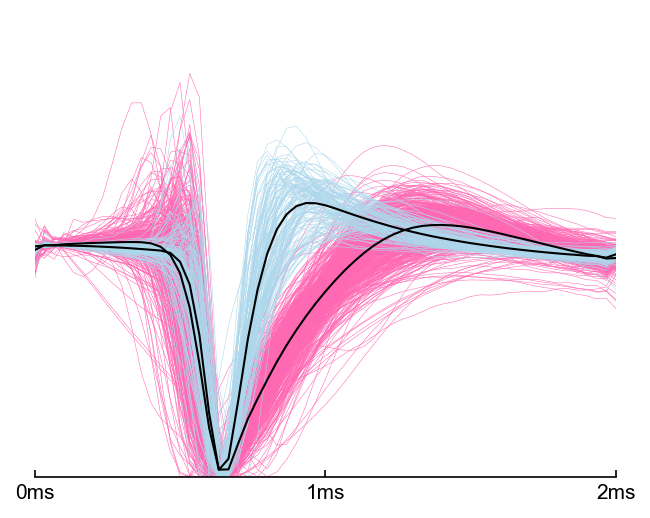

In [137]:
narrow_waveforms = normWFs[narrow_mask,:]
mean_narrow_waveform = np.mean(narrow_waveforms,axis=0)
sem_narrow_waveform = sem(narrow_waveforms,axis=0)

broad_waveforms = normWFs[broad_mask,:]
mean_broad_waveform = np.mean(broad_waveforms,axis=0)
sem_broad_waveform = sem(broad_waveforms,axis=0)

fig,ax = plt.subplots(figsize=(5,4))
ax.spines[['left','right','top']].set_visible(False)
ax.set_ylim([-1,1])
ax.set_yticks([])
ax.set_xlim([0,60])
ax.set_xticks([0,30,60])
ax.set_xticklabels(['0ms','1ms','2ms'])

ax.plot(narrow_waveforms.T,c=NARROW_COLOR,lw=0.25,zorder=2)
ax.plot(broad_waveforms.T,c=BROAD_COLOR,lw=0.25,zorder=1)

ax.plot(mean_narrow_waveform,zorder=5,lw=1,c='k')
ax.plot(mean_broad_waveform,zorder=5,lw=1,c='k')
pass

plt.savefig('C:\\Users\\4thgr\\Downloads\\BroadNarrowWaveformsOpsin.pdf')

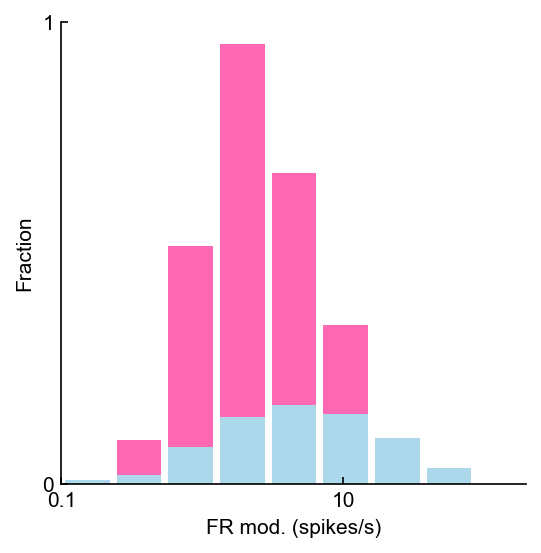

In [30]:
mn = np.log10(3.5)
spread = 1.5

fig,ax = plt.subplots(figsize=(4,4))

buffer = 0.025

data = narrow_FRmod
# data[data==0] = 0.1
data = np.log10(data)
counts,edges = np.histogram(ilep.rmnan(data),bins=9,range=[-1,np.log10(200)])
for idx,count in enumerate(counts):
    FRmod = np.mean([10**edges[idx],10**edges[idx+1]])
    color = NARROW_COLOR
    #color = NCR_CR_cmap( (np.log10(FRmod)-(mn-spread/2))/ (spread) )
    ax.fill_between([edges[idx]+buffer,edges[idx+1]-buffer],[count],color=color,lw=0)
    # ax.hist(data,bins=10,log=False)
# ax.axvline(np.log10(np.median(ilep.rmnan(phase_data))),color=NCR_CR_cmap( (np.log10(np.median(ilep.rmnan(phase_data)))-(mn-spread/2))/ (spread) ))

data = broad_FRmod
# data[data==0] = 0.1
data = np.log10(data)
counts,edges = np.histogram(ilep.rmnan(data),bins=9,range=[-1,np.log10(200)])
for idx,count in enumerate(counts):
    FRmod = np.mean([10**edges[idx],10**edges[idx+1]])
    color = BROAD_COLOR
    #color = NCR_CR_cmap( (np.log10(FRmod)-(mn-spread/2))/ (spread) )
    ax.fill_between([edges[idx]+buffer,edges[idx+1]-buffer],[count],color=color,lw=0,zorder=-10)
    # ax.hist(data,bins=10,log=False)
# ax.axvline(np.log10(np.median(ilep.rmnan(phase_data))),color=NCR_CR_cmap( (np.log10(np.median(ilep.rmnan(phase_data)))-(mn-spread/2))/ (spread) ))

ax.set_xlim([-1,np.log10(200)])
ax.set_xticks([-1,1])
ax.set_xticklabels([0.1,10])

ylims = ax.get_ylim()
ylims = (0,ylims[1])
ax.set_ylim(ylims)
ax.set_yticks(ylims)
ax.set_yticklabels([0,1])

xlab = ax.set_xlabel('FR mod. (spikes/s)')
ylab = ax.set_ylabel('Fraction')
#     ax.set_title(phase)

# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2)
# ax.tick_params(width=2)
# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#     ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(30)
    
artists = [xlab,ylab]
plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapBroadNarrowHistOpsin.pdf')

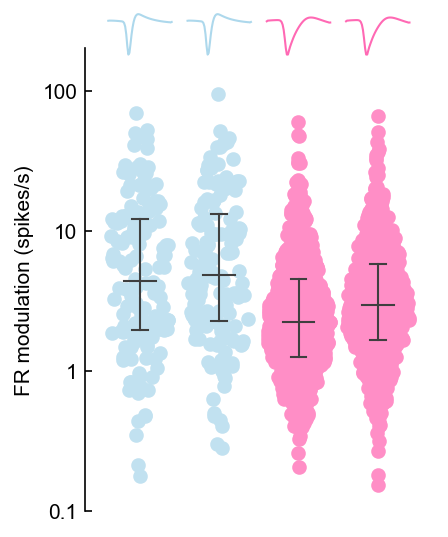

In [129]:
# embedding = reducer.fit_transform(normWFs)
# umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
# umap_df['waveform'] = list(normWFs)
# umap_df['cluster_id'] = clustering_solution

fig,ax = plt.subplots(figsize=(3,4))
ax.spines[['right','top','bottom']].set_visible(False)
ax.set_xticks([])
ylab = ax.set_ylabel('FR modulation (spikes/s)')
ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill_between([-0.5,3.5],ylim[0],ylim[1],lw=0,fc='white',alpha=0.25,zorder=4)

masks = [narrow_mask,narrow_mask,broad_mask,broad_mask]
conditions = ['laser_off','laser_on','laser_off','laser_on']
for Xpos,mask in enumerate(masks):
    
    #Calculate waveform
    clust_waveforms = normWFs[mask,:]
    mean_waveform = np.mean(clust_waveforms,axis=0)
    sem_waveform = sem(clust_waveforms,axis=0)
    
    #Calculate color
    colors = [NARROW_COLOR,NARROW_COLOR,BROAD_COLOR,BROAD_COLOR,'blue','blue']
    rgba = colors[Xpos]
    
    #Plot scatter
    if Xpos in [0,2]:
        X,_ = ilep.violin(np.log10(np.array(FRmods_off)[mask]))
        Y = np.array(FRmods_off)[mask]
        [q1,q2,q3] = np.percentile(ilep.rmnan(np.array(FRmods_off)[mask]),[25,50,75])
    elif Xpos in [1,3]:
        X,_ = ilep.violin(np.log10(np.array(FRmods_on)[mask]))
        Y = np.array(FRmods_on)[mask]
        [q1,q2,q3] = np.percentile(ilep.rmnan(np.array(FRmods_on)[mask]),[25,50,75])
    ax.scatter(X+Xpos,Y, marker='o', c=rgba,zorder=0,clip_on=False)
    ax.plot([Xpos]*2,[q1,q3],c='k',lw=1)
    ax.plot([Xpos-0.2,Xpos+0.2],[q2,q2],lw=1,c='k')
    ax.plot([Xpos-0.1,Xpos+0.1],[q1,q1],lw=1,c='k')
    ax.plot([Xpos-0.1,Xpos+0.1],[q3,q3],lw=1,c='k')

    #Plot waveform
    meanX = Xpos
    meanY = 2.5
    total_x_range = 0.4
    total_y_range = 0.25
    xrange = np.linspace(meanX-total_x_range,meanX+total_x_range,num=61)
    y_adj = mean_waveform * total_y_range + meanY
    ysem_adj = sem_waveform * total_y_range
    ax.plot(xrange,10**(y_adj),c=rgba,lw=1,zorder=5,clip_on=False)
    ax.fill_between(xrange,10**(y_adj-ysem_adj),10**(y_adj+ysem_adj),alpha=1,lw=0,fc=rgba,zorder=4,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,ttl]
plt.savefig('C:\\Users\\4thgr\\Downloads\\WavemapClustersVsFRmodOpsinOnOff.pdf', bbox_extra_artists=(artists), bbox_inches='tight')

In [130]:
narrow_FRmod_off = ilep.rmnan(np.array(FRmods_off)[narrow_mask])
narrow_FRmod_on = ilep.rmnan(np.array(FRmods_on)[narrow_mask])
broad_FRmod_off = ilep.rmnan(np.array(FRmods_off)[broad_mask])
broad_FRmod_on = ilep.rmnan(np.array(FRmods_on)[broad_mask])
narrow2_FRmod_off = ilep.rmnan(np.array(FRmods_off)[narrow2_mask])
narrow2_FRmod_on = ilep.rmnan(np.array(FRmods_on)[narrow2_mask])

In [131]:
normaltest(narrow_FRmod_off)

NormaltestResult(statistic=85.6720412601093, pvalue=2.4920262556185974e-19)

In [132]:
normaltest(narrow_FRmod_on)

NormaltestResult(statistic=110.43103711812287, pvalue=1.047622878937335e-24)

In [133]:
normaltest(broad_FRmod_off)

NormaltestResult(statistic=546.2579282730059, pvalue=2.407675910650678e-119)

In [134]:
normaltest(broad_FRmod_on)

NormaltestResult(statistic=513.1148037356804, pvalue=3.7891000894864468e-112)

In [135]:
mannwhitneyu(narrow_FRmod_off,narrow_FRmod_on)

MannwhitneyuResult(statistic=9573.0, pvalue=0.4624595981450139)

In [136]:
mannwhitneyu(broad_FRmod_off,broad_FRmod_on)

MannwhitneyuResult(statistic=120169.5, pvalue=4.714453156169511e-05)

In [119]:
mannwhitneyu(narrow2_FRmod_off,narrow2_FRmod_on)

MannwhitneyuResult(statistic=3585.0, pvalue=0.3966009771302723)

In [103]:
#Note that currently, due to code below, these must go [0,1,2,3,4,...]
UMAP_reducer_seed_list = list(range(3))
louvain_seed_list = list(range(5))
resolution_list = np.linspace(0.2,2,num=20)

# Set up parallel engines

In [97]:
rc = Client()
dv = rc[:]
dv.block = True
dv.activate()
print("Number of active engines: {0}".format(len(dv)))

Number of active engines: 6


In [98]:
%%px --block

import numpy as np
from umap import umap_ as umap
import networkx as nx

#%load_ext autoreload
#%autoreload 2

%px:   0%|          | 0/6 [00:01<?, ?tasks/s]

[stderr:1] C:\Users\4thgr\anaconda3\envs\InsanallyLabENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[stderr:4] C:\Users\4thgr\anaconda3\envs\InsanallyLabENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[stderr:5] C:\Users\4thgr\anaconda3\envs\InsanallyLabENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[stderr:0] C:\Users\4thgr\anaconda3\envs\InsanallyLabENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[stderr:3] C:\Users\4thgr\anaconda3\envs\InsanallyLabENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[stderr:2] C:\Users\4thgr\anaconda3\envs\InsanallyLabENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


%px: 100%|██████████| 6/6 [00:14<00:00,  2.38s/tasks]


In [99]:
def calculate_clustering(normWFs,params):
    UMAP_reducer_seed,louvain_seed,resolution = params
    
    reducer = umap.UMAP(n_neighbors=15, n_jobs=1, random_state=UMAP_reducer_seed)
    mapper = reducer.fit(normWFs)
    
    G = nx.from_scipy_sparse_array(mapper.graph_)
    temp_solution = nx.community.louvain_communities(G,resolution = resolution,seed=louvain_seed)
    modularity = nx.algorithms.community.quality.modularity(G, temp_solution) 

    return temp_solution,modularity,params

# Run parallel clustering

In [104]:
t1 = time.time()
params = list(product(UMAP_reducer_seed_list,louvain_seed_list,resolution_list))
res = dv.map_sync(calculate_clustering,[normWFs]*len(params),params)
t2 = time.time()

time_elapsed = t2-t1
mins_elapsed = np.floor((time_elapsed)/60)
secs_elapsed = time_elapsed - mins_elapsed*60
print(f"Time elapsed: {mins_elapsed} minutes and {secs_elapsed} seconds")

Time elapsed: 7.0 minutes and 5.430636882781982 seconds


In [105]:
results = dict()
for r in np.unique(resolution_list):
    results[r] = []

for temp_solution,modularity,params in res:
    UMAP_seed,louvain_seed,resolution = params
    results[resolution].append(modularity)

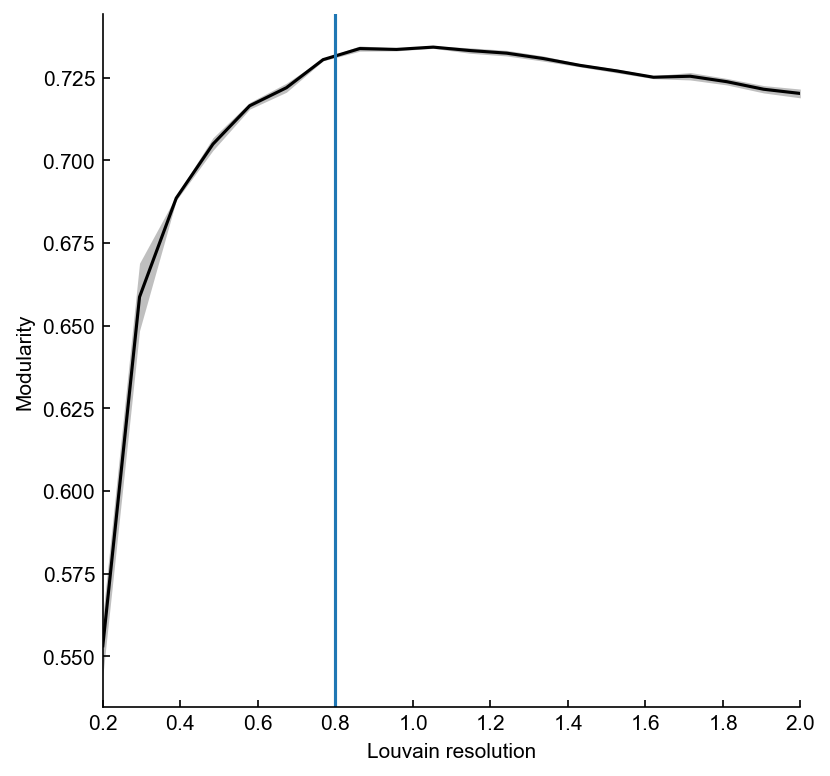

In [163]:
X = np.sort(list(results.keys()))
Y = np.array([np.mean(results[x]) for x in X])
Y_sem = np.array([sem(results[x]) for x in X])

fig,ax = plt.subplots(figsize=(6,6))
ax.plot(X,Y,c='k')
ax.fill_between(X,Y-Y_sem,Y+Y_sem,color='k',alpha=0.25,lw=0)
ax.axvline(0.8)
# ax.axvline(1.1)

ax.set_xlim([np.min(X),np.max(X)])

ax.set_ylabel('Modularity')
ax.set_xlabel('Louvain resolution')

plt.savefig('C:\\Users\\4thgr\\Downloads\\ResolutionSelection.pdf')